![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

## Data Fields
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather  
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
#bikes.groupby('workingday').total.mean()
std_descriptive = bikes.groupby('workingday').total.describe()
std_descriptive["cv"] = std_descriptive["std"] / std_descriptive["mean"]
std_descriptive

,count,mean,std,min,25%,50%,75%,max,cv
workingday,,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0,0.921580
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0,0.955971


#### Inferrencias:
- El número total bicicletas rentadas es mayor para los dias que son laborables.
- En promedio se rentan más bicicletas los laborables que los NO laborables.
- La desviación estandar de la cantidad de las bicicletas que se rentan los dias NO laborables es menor lo que indica que los datos se encuentran más agrupados al rededor de la media o el promedio.

In [5]:
# Celda 1.2
#bikes.groupby('hour').total.mean()
std_descriptive = bikes.groupby('hour').total.describe()
std_descriptive["cv"] = std_descriptive["std"] / std_descriptive["mean"]
std_descriptive.loc[[8,12,13,17,18],:]
#(bikes.groupby('hour').total.describe()["std"] / bikes.groupby('hour').total.describe()["mean"])

,count,mean,std,min,25%,50%,75%,max,cv
hour,,,,,,,,,
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.5,839.0,0.638762
12,456.0,256.508772,143.881880,3.0,157.00,234.5,332.0,757.0,0.560924
13,456.0,257.787281,149.167185,11.0,154.00,226.5,329.0,729.0,0.578644
17,456.0,468.765351,223.775485,15.0,277.00,480.5,608.5,970.0,0.477372
18,456.0,430.859649,219.908138,23.0,240.75,422.5,564.0,977.0,0.510394


#### Inferrencias:
- Las horas donde se rentan más bicicletas corresponden a las 8,12 y 18 horas.
- En promedio las horas en las cuales se rentan mas bicicletas son 8,13 y las 17 horas.
- De las horas en las cuales se rentan mas bicicletas, en la hora en la cual se presenta menor varibilidad es a las 17 horas mientras que a las 8 horas se presenta la mayor vairabilidad.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
#bikes.groupby('hour').total.mean().plot()

<AxesSubplot:title={'center':'Rentas promedio de bicibletas por hora'}, xlabel='hour', ylabel='total'>

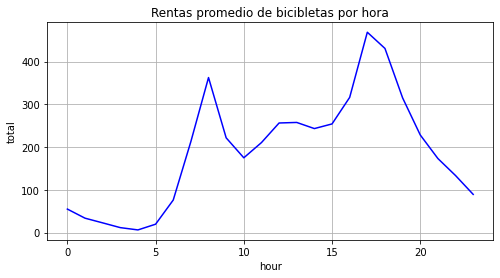

In [7]:
bikes.pivot_table(index="hour",values="total",aggfunc=np.mean).plot(colormap='winter',
    legend=False,ylabel="total",figsize=(8,4),grid=True, title="Rentas promedio de bicibletas por hora")

<AxesSubplot:title={'center':'Rentas promedio de bicibletas por hora cuando NO es un dia laboral'}, xlabel='hour', ylabel='total'>

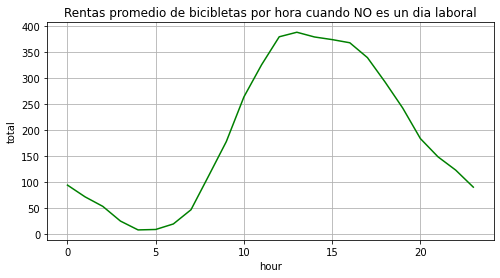

In [8]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes.pivot_table(index="hour",values="total",columns="workingday",aggfunc=np.mean)[0].plot(colormap='ocean',
    legend=False,ylabel="total",figsize=(8,4),grid=True, title="Rentas promedio de bicibletas por hora cuando NO es un dia laboral")

<AxesSubplot:title={'center':'Rentas promedio de bicibletas por hora cuando es un dia laboral'}, xlabel='hour', ylabel='total'>

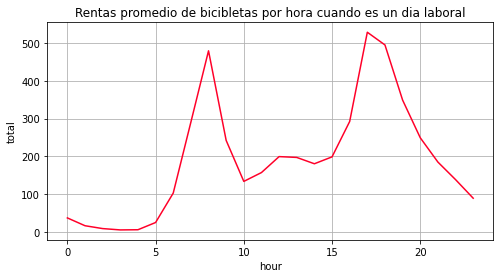

In [9]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes.pivot_table(index="hour",values="total",columns="workingday",aggfunc=np.mean)[1].plot(colormap='gist_rainbow',
    legend=False,ylabel="total",figsize=(8,4),grid=True, title="Rentas promedio de bicibletas por hora cuando es un dia laboral")

### Hallazgos
- La curva de las  rentas promedio por hora tiene un comportamiento similar a la misma en los diaslaborables.
- Claramente las curvas de rentas promedio dependiendo sí el dia es laboral o no, muestran que las horas pico donde se se presentan la mayor cantidad de rentas de bicicletas son diferentes aunque al rededor de las 12horas existe un alto promedio demanda tanto en los dias laborales como en los que NO son laborables.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

<AxesSubplot:>

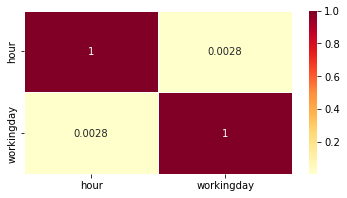

In [10]:
corr= bikes[["hour","workingday"]].corr()
fig, ax = plt.subplots(figsize=(6,3)) 
sns.heatmap(corr,annot=True,linewidths=0.5, ax=ax, cmap="YlOrRd")

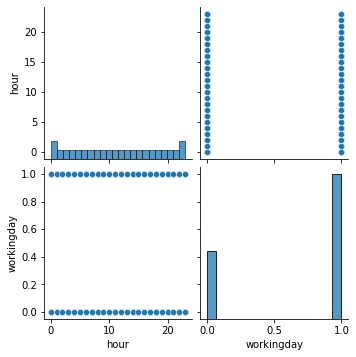

In [11]:
sns.pairplot(bikes[["hour","workingday"]], kind="scatter")
plt.show()

In [12]:
# Celda 3
X,y = bikes[["hour","workingday"]].values, bikes["total"].values
XTrain, XTest, yTrain, yTest  = train_test_split(X,y, test_size=0.33, random_state=0)

In [13]:
l_model = LinearRegression()
l_model.fit(XTrain, yTrain)
l_model.coef_

array([10.55099422,  6.770441  ])

In [14]:
R2 = l_model.score(XTrain, yTrain)
# r2adjModelo=1-(1-r2Modelo)*(nTrain-1)/(nTrain-nc-1)
nTrain = len(XTrain)
nc = len(l_model.coef_)
R2adj =  1- (1-R2)*(nTrain-1)/(nTrain-nc-1)
print(R2adj)

0.1633021594440015


In [15]:
MSE_train = np.average(np.square(l_model.predict(XTrain) - yTrain))
MSE_test = np.average(np.square(l_model.predict(XTest) - yTest))
print(MSE_train, MSE_test)

27490.75276391773 27657.435595059633


#### Interpretación coeficientes:
Los coeficientes se pueden interpretar de la siguiente manera:
- hour: Dependiendo de la hora del dia, la cantidad de bicicletas rentadas aumenta 10.55 veces.
- workingday: Dependiendo de que se es dia labora o no, la cantidad de bicicletas rentadas aumenta 6.77 veces.

#### ¿Cuales son las limitaciones de la regresion lineal en este caso?
- La cantidad de información que aportan las variables "hour" y "workingday"es muy poca, por lo que estas no logran explicar la varible predictora lo cual se evidencia al calcular el R^2 ajsutado (0.163). 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [16]:
# Celda 4


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [17]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
#from sklearn.model_selection import cross_val_score
#from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring="r2").mean())

Text(0, 0.5, 'r2')

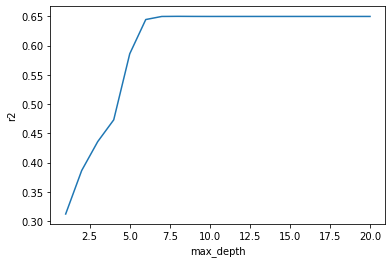

In [18]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')

In [19]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6501337581022684, 8)

In [20]:
# max_depth=8 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf.fit(XTrain, yTrain)
MSE_train = np.average(np.square(clf.predict(XTrain) - yTrain)) 
MSE_test = np.average(np.square(clf.predict(XTest) - yTest))
print(MSE_train, MSE_test)

11317.868125442446 11421.13577122465


#### Comentarios:
Para evaluar el desempeño del modelo se utilziaron las métricas de r2 y MSE encontrando una mejora considerable del desempeño del modelo. Lo más relevante es que utilizando en arbol de decisión con solamente dos variables tiene unas mejores métricas de desempeño. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [21]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [22]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [23]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [24]:
max_depth_range = range(1, 21)
accuracy_scores = []

for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring="accuracy").mean())
    

depth = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]
depth

9

In [25]:
# Celda 6
# Definición de 2 modelos diferentes: regresión logística y árbol de decisión
models = {'lr': LogisticRegression(),
          'dt': DecisionTreeClassifier(max_depth=depth,random_state=1)}

In [26]:
# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

In [27]:
# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

In [28]:
# Evaluación del error de cada modelo

for model in models.keys():
    print(model,np.sqrt(accuracy_score(y_pred[model], y_test)),np.sqrt(f1_score(y_pred[model], y_test)))

lr 0.7835815209663893 0.7814252493420901
dt 0.7763160868271807 0.7870276462515405


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

#### Modelo 1 - 100 árboles de decisión donde max_depth = None

In [29]:
# Celda 7
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [30]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.642384105960265, 0.64)

#### Modelo 2 - 100 árboles de decisión donde max_depth = 2

In [31]:
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [32]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.6439545758183033, 0.6446666666666667)

#### Modelo 3 -100 regresiones logísticas

In [33]:
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [34]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.6136210384356034, 0.618)

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

#### Modelo 1 - 100 árboles de decisión donde max_depth = None

In [35]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.6513761467889909, 0.6453333333333333)

#### Modelo 2 - 100 árboles de decisión donde max_depth = 2

In [36]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.6448598130841121, 0.6453333333333333)

#### Modelo 3 -100 regresiones logísticas

In [37]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
f1_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.6140350877192983, 0.6186666666666667)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [38]:
# Celda 9